In [1]:
import pandas as pd
import numpy as np
import math
from wdmtoolbox import wdmtoolbox
from tstoolbox import tstoolbox
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
def ET_cal(df1,Latitude,Longitude,Elev,Windheight,outputfile,Humidty,Solar):
    
    #df1 is a dataframe with DateTimeIndex at Freq= 1 hour
    # FOA Using FOA Perman Monteith equation 
    # http://www.fao.org/docrep/X0490E/x0490e00.htm#Contents
    
    # Humity =True, Humidity will beestimated from the Dew point
    # Solar=Ture, 'Solar Rad(SUM), MJ/m^2/h' will be estimated
    
    df1["Latitude Radians"]=((np.pi) * (Latitude / 180))
    df1["Longitude degree"]=Longitude
    df1["Elevation (m)"]=Elev
    
        
    
    df1["Saturated Vapor Pressure"] = ((0.6108) * ((np.e) **
                                   ((17.27 * df1["Temp, *C"]) / (df1["Temp, *C"] + 237.3))))
    if Humidty:
            df1["Actual Vapor Pressure"] =(0.6108*((np.e)**
                                         ((17.27 * df1["DewPt, *C"]) / (df1["DewPt, *C"] + 237.3)))) 
            df1['RH, %']=df1["Actual Vapor Pressure"]/df1["Saturated Vapor Pressure"]*100.0
    else:
        df1["Actual Vapor Pressure"] = (df1['RH, %'] / 100)*df1["Saturated Vapor Pressure"]  
    
    DOY_temp=[]
    Vtemp=0.0
    for i in range(0, len(df1)):
        Mth=df1.index[i].month
        Dayt=df1.index[i].day
        Yeart=df1.index[i].year
        Vtemp=int(275*Mth/9-30+Dayt)-2
        if Mth<3: Vtemp=Vtemp+2
        if(Yeart%4==0 and Mth>2): Vtemp=Vtemp+1
        DOY_temp.append(Vtemp)

    df1["Day of Year"]=DOY_temp
 # CALCULATE THE INVERSE DISTANCE (dr^2)
    df1["Inverse Distance"] = (1 + 0.033 * np.cos((2 * np.pi / 365) * df1['Day of Year']))
    # CALCULATE THE SOLAR DECLINATION (S)
    df1["Solar Declination"] = (0.409 * np.sin(((2 * np.pi / 365) * df1['Day of Year']) - 1.39))
    # CALCULATE THE SUNSET HOUR ANGLE (Ws)

    b_temp=2.0*np.pi*(df1['Day of Year']-81)/364.0

    df1["Sc"]=0.1645*np.sin(2.0*b_temp)-0.1255*np.cos(b_temp)-0.025*np.sin(b_temp)  
    df1["solar time angle mid"]=np.pi/12.0*((df1.index.hour+0.5+0.06667*(90.0-df1["Longitude degree"])+ df1["Sc"])-12.0)

    df1["Sunset Hour Angle"] = np.arccos(
        (-np.tan(df1["Latitude Radians"])) * (np.tan(df1["Solar Declination"])))

    df1["solar time angle beg"]= df1["solar time angle mid"] - np.pi/24.0  
    df1["solar time angle end"]= df1["solar time angle mid"] + np.pi/24.0   
    num=df1["solar time angle beg"]._get_numeric_data()
    num1=df1["Sunset Hour Angle"]._get_numeric_data()
    num2=df1["solar time angle end"]._get_numeric_data()
    num3=df1["solar time angle mid"]._get_numeric_data()
    num[num<-num1]=-num1
    num[num>num1]=num1
    num2[num2<-num1]=-num1
    num2[num2>num1]=num1
    num[num>num2]=num2
    num3[num3<num]=num
    df1["Extraterrestrial Radiation"] = (((12 / np.pi) * 4.92 * df1["Inverse Distance"])*
                                   ((df1["solar time angle end"]-df1["solar time angle beg"]) *
                                   np.sin(df1["Solar Declination"])*np.sin(df1["Latitude Radians"]) +
                                   np.cos(df1["Solar Declination"]) *np.cos(df1["Latitude Radians"])* 
                                   (np.sin(df1["solar time angle end"])-np.sin(df1["solar time angle beg"]))))      
       # CALCULATE CLEAR SKY RADIATION (Rso)
    df1["Clear Sky Radiation"] = (
        0.75 + (0.00002 * df1["Elevation (m)"])) * df1["Extraterrestrial Radiation"]
   # num=df1["Clear Sky Radiation"]._get_numeric_data()
   #num[num<0]=0
    
    # CALCULATE NET OUTGOING LONGWAVE RADIATION (Rnl)
    Y_temp = (np.sin(df1["Latitude Radians"])*np.sin(df1["Solar Declination"]) 
          + np.cos(df1["Latitude Radians"])*np.cos(df1["Solar Declination"])*np.cos(df1["solar time angle mid"]))
    df1["angle of the sun"]=np.arctan(Y_temp/((1-Y_temp*Y_temp)**0.5))
    
    if Solar:
            df1['Solar Rad(SUM), MJ/m^2/h']=(0.75+2.0*0.00001*df1["Elevation (m)"])*df1["Extraterrestrial Radiation"]
       
    df1["Rs/Rso"]=df1['Solar Rad(SUM), MJ/m^2/h']/df1["Clear Sky Radiation"]
    
    df1["Rs/Rso"]=df1["Rs/Rso"].replace([np.inf, -np.inf],0)
    df1["Rs/Rso"]=df1["Rs/Rso"].replace(np.nan,0)
    nut1=df1["Rs/Rso"]._get_numeric_data()
    nut1[nut1>1]=1
    nut1[nut1<0.3]=0.3    
    fcd_temp=[]
    fcb=0.0
    for i in range(0, len(df1)):
        beta1=df1.iloc[i]["angle of the sun"]
        if (i+1) <len(df1):
            beta2=df1.iloc[i+1]["angle of the sun"]        
        if(beta1 > 0.3 and beta2 < 0.3):
            fcb=1.35*df1.iloc[i]["Rs/Rso"]-0.35
        atemp=1.35*df1.iloc[i]["Rs/Rso"]-0.35
        if fcb<0.05: fcb=0.055
        if beta1<0.3: atemp = fcb
        fcd_temp.append(atemp)

    df1['Fcd']=fcd_temp
        # hourly SATURATION VAPOR PRESSURE CALCULATIONS
    # VA
    df1["Vah"] = (0.6108) * (np.e **((17.27 * df1["Temp, *C"]) / (df1["Temp, *C"] + 237.3)))
    # FINAL (TOGETHER)// Va*
    df1["Saturated Vapor Pressure"] = 0.6108 * (np.e**((17.27 * df1["Temp, *C"]) / (df1["Temp, *C"] + 237.3)))
    # MEAN hourly ACTUAL VAPOR PRESSURE CALC (Va)
    df1["Actual Vapor Pressure"] = df1["Vah"] * (df1['RH, %'] / 100) 
    df1["Wind Speed, m/s at 2m"]=df1["Wind Speed, m/s"]*4.87/np.log(67.8*Windheight-5.42)
    df1["Function"] = (df1["Wind Speed, m/s at 2m"] * (df1["Saturated Vapor Pressure"] - df1["Actual Vapor Pressure"]))
    # SLOPE OF VAPOR PRESSURE CURVE
    df1["Slope Of Vapor Pressure"] = (4098 * 0.6108 * (np.e ** (17.27 * df1["Temp, *C"] / (df1["Temp, *C"] + 237.3)))
                                 / ((df1["Temp, *C"] + 237.3)**2))    
    df1["Net Outgoing Longwave"] = ((2.042 * (10**(-10)))*df1['Fcd']*(0.34 - (0.14 * (df1["Actual Vapor Pressure"]**0.5))) *
                                ((df1['Temp, *C'] + 273.3) ** 4)) 
    # CALCULATE NET INCOMING SHORTWAVE RADIATION
#df1["Net Incoming Shortwave Rad"] = (1 - 0.08) * df1["Solar Rad(SUM), MJ/m^2/h"]
    df1["Net Incoming Shortwave Rad"] = (1 - 0.23) * df1["Solar Rad(SUM), MJ/m^2/h"]
    # CALCULATE RADIATION ESTIMATE CALCULATION
    df1["Net Radiation Est"] = df1["Net Incoming Shortwave Rad"] - df1["Net Outgoing Longwave"]    
#----------------------------------------------------------------------
    # {PSYCHROMETRIC CONSTANT & ATMOSPERIC PRESSURE VARIABLE}

    # ATMOSPHERIC PRESSURE VARIABLE (ROW) - CONSTANT FOR EACH SITE
    df1["Atmospheric Pressure"] = 101.3 *(((293 - 0.0065 * df1["Elevation (m)"]) / 293)**5.26)
    df1["Psychrometric Constant"] = (0.00163) * (df1["Atmospheric Pressure"] / 2.45)   
    Gos_temp=[]
    for i in range(0, len(df1)):
        Rn=df1.iloc[i]["Net Radiation Est"]
        if Rn>0:
            Gostemp=0.1*Rn
        else: 
            Gostemp=0.5*Rn
        
        Gos_temp.append(Gostemp)
    
    df1["G soil"]=Gos_temp


    df1["ET Part1"]=df1["Slope Of Vapor Pressure"]*0.408*(df1["Net Radiation Est"]-df1["G soil"])

    df1["ET Part2"]=df1["Psychrometric Constant"]*37.0/(df1['Temp, *C']+273.16)*df1["Function"]   #*(df1["Net Radiation Est"]-df1["G tall rs"])

    df1["ET Part3"]=df1["Slope Of Vapor Pressure"] + df1["Psychrometric Constant"]*(1+0.34*df1["Wind Speed, m/s at 2m"])

    df1["FOA ET hourly Rate (mm)"]=(df1["ET Part1"]+df1["ET Part2"])/df1["ET Part3"]
 
    nuET = df1["FOA ET hourly Rate (mm)"]._get_numeric_data()
    nuET[nuET<0]=0
    # FINAL CORRECT DAILY ET VALUES -> mm to inches
    df1["FOA ET hourly Rate (IN)"] = df1["FOA ET hourly Rate (mm)"] * 0.0393701
    df1.to_csv(Outputfile)
    onlyET=df1["FOA ET hourly Rate (IN)"]
  
    return  onlyET


In [3]:
def normalizedET(onlyETin):
    
    Factor_ETin=onlyETin.div(onlyETin.resample('M').transform('sum'))
    datep=onlyETin.index[0].strftime('%Y/%m')
    days=onlyETin.index[0].daysinmonth
    dayt=onlyETin.index[0].day
    Hourt=onlyETin.index[0].hour
    ncount=days*24-(dayt*24-24-Hourt+1)
    ratio=(days*24-(dayt*24-24-Hourt+1))/(days*24)
    for i in range(0,ncount):
         if  Factor_ETin.index[i].strftime('%Y/%m')==datep :
                Factor_ETin.iloc[i]=Factor_ETin.iloc[i]*ratio
    n=len(Factor_ETin)
    datep=Factor_ETin.index[n-1].strftime('%Y/%m')
    datep=onlyETin.index[n-1].strftime('%Y/%m')
    days=onlyETin.index[n-1].daysinmonth
    dayt=onlyETin.index[n-1].day
    Hourt=onlyETin.index[n-1].hour
    ncount=dayt*24-24+Hourt
    ratio=(dayt*24-24+Hourt)/(days*24)
    for i in range(n-1, n-ncount-1,-1):
         if Factor_ETin.index[i].strftime('%Y/%m')==datep :
                Factor_ETin.iloc[i]=Factor_ETin.iloc[i]*ratio
    return Factor_ETin

In [4]:
def prepare_WeatherData(dfMaster):
#Time-time
# Air temp oF
# Atomospheric pressure Inhg
# Dew Point oF
# Precipitation in
# Relative humidity (%)
# Soil moisture Sallow (%)
# Soil moisture deep (%)
# Solar rad (kW/m^2)
# Wind direction deg
# WInd Gust mph
# Wind Vel  mph
    #dfMaster = pd.read_csv(Inputfile, skiprows=range(1,3))    
    for col in dfMaster.columns:
        if ('Time,' not in col and 'Daylight' not in col and
        'Date' not in col and 'Time' not in col):
           
            dfMaster[col] = dfMaster[col].astype(np.float64)
            #print("k is : " + str(k))
            #print(dfMaster.dtypes[col])
            if ('RH, %' in col) or ('Rel' in col and 'Hum' in col):
                dfMaster.rename(columns={col:'RH, %'},inplace=True)
            if ('Solar Radiation, KW/m2' in col) or ('Solar' in col):
                dfMaster.rename(columns={col:'Solar Rad, KW/m^2'},inplace=True)
            if 'Deep' in col:
                dfMaster.rename(columns={col:'Water Content, m^3/m^3, Deep'},inplace=True)
            if 'Shallow' in col:
                dfMaster.rename(columns={col:'Water Content, m^3/m^3, Shallow'},inplace=True)
            if 'Wind Dir' in col:
                dfMaster.rename(columns={col:'Wind Dir, *'},inplace=True)
            if (('Rain, in' in col) or 
                ('Precip ' in col ) or
                ('Rain' in col and ' in' in col and 'mm' not in col)):
                    dfMaster.rename(columns={col:'Rain, in'},inplace=True)  
            if (('Air Temp' in col) or
                 ('temp' in col and 'C' not in col) or
                 ('Temp' in col and 'C' not in col)):
                    dfMaster.rename(columns={col:'Temp, *F'},inplace=True)
            if (('Wind Vel' in col)):
                    dfMaster.rename(columns={col:'Wind Speed, mph'},inplace=True)
            if (('Gust Speed, mph') in col or
                ('gust' in col) or
                ('Gust' in col )): 
                    dfMaster.rename(columns={col:'Gust Speed, mph'},inplace=True)
            if (('Dew Point, *F' in col) or
                ('dew' in col) or
                ('Dew' in col)):
                    dfMaster.rename(columns={col:'DewPt, *F'},inplace=True)
            if ('Pressure, inHg' in col) or 'Atmos Pres' in col:
                dfMaster.rename(columns={col:'Pressure, inHg'},inplace=True)
        elif 'Time,' in col:
            dfMaster[col] = dfMaster[col].astype(str)
            dfMaster.rename(columns={col:'Date'},inplace=True)
        elif ('Daylight' in col or ('Daylight' in col and 'Time' in col)):
            dfMaster[col] = dfMaster[col].astype(str)
            dfMaster.rename(columns={col:'Time'},inplace=True)        
    if 'Temp, *F' in dfMaster.columns:        
        dfMaster['Temp, *F'] = dfMaster['Temp, *F'].astype(np.float64)
        dfMaster['Temp, *C'] = (dfMaster['Temp, *F'] - 32) / 1.8
    if 'Rain, in' in dfMaster.columns:
        dfMaster['Rain, in'] = dfMaster['Rain, in'].astype(np.float64)
        dfMaster['Rain, mm'] = dfMaster['Rain, in'] * 25.4
    if 'Pressure, inHg' in dfMaster.columns:
        dfMaster['Pressure, inHg'] = dfMaster['Pressure, inHg'].astype(np.float64) 
        dfMaster['Pressure, kPa'] = dfMaster['Pressure, inHg'] * 3.38638816
        dfMaster['Pressure, mbar'] = dfMaster['Pressure, inHg'] * 33.8639
    if 'Gust Speed, mph' in dfMaster.columns:
        dfMaster['Gust Speed, mph'] = dfMaster['Gust Speed, mph'].astype(np.float64)
        dfMaster['Gust Speed, m/s'] = dfMaster['Gust Speed, mph'] * 0.44704
    if 'Wind Speed, mph' in dfMaster.columns:
        dfMaster['Wind Speed, mph'] = dfMaster['Wind Speed, mph'].astype(np.float64)
        dfMaster['Wind Speed, m/s'] = dfMaster['Wind Speed, mph'] * 0.44704
    if 'DewPt, *F' in dfMaster.columns:
        dfMaster['DewPt, *F'] = dfMaster['DewPt, *F'].astype(np.float64)
        dfMaster['DewPt, *C'] = (dfMaster['DewPt, *F'] - 32) / 1.8
    if 'Rain, in' in dfMaster.columns:
        dfMaster['Rain, in'] = dfMaster['Rain, in'].astype(np.float64)
        dfMaster['Rain, mm'] = dfMaster['Rain, in'] * 25.4        
    
    dfMaster=dfMaster.rename(columns={'Date-Time':'Datehour'})

    dfMaster = dfMaster.set_index(pd.DatetimeIndex(dfMaster['Datehour']))
    
    dfMaster=dfMaster.resample("15T").mean()
    return dfMaster


In [5]:
def rearrange_dataframe(dfMaster):
    for row in range(len(dfMaster)):
        for col in range(len(dfMaster.columns)):
            atemp=dfMaster.iloc[row,col]
            if math.isnan(atemp):
           # dfMaster=dfMaster.replace(dfMaster.iloc[row,col],dfMaster.iloc[row-24,col])
                dfMaster.iloc[row,col]=dfMaster.iloc[row-24,col]    
  
    avgData=dfMaster.resample('H').mean()
    dfMaster['Solar Rad(SUM), MJ/m^2/h'] = (dfMaster['Solar Rad, KW/m^2']-0.001) *3.6*0.25
    solarMJ = dfMaster['Solar Rad(SUM), MJ/m^2/h'].resample('H').sum()
   # del avgData['Solar Rad(SUM), MJ/m^2/h']
    merged = pd.concat([avgData, solarMJ],axis=1)
    merged.reset_index(inplace=True)
    df1 = merged.filter(items=['Datehour','Pressure, kPa',
                           'RH, %', 'DewPt, *C', 'Temp, *C', 'Solar Rad(SUM), MJ/m^2/h','Wind Speed, m/s']) 
    df1=df1.set_index(pd.DatetimeIndex(df1['Datehour']))
    
    return df1

In [6]:
def read_TWDBlakesurface(fileETmonth):
   # return the TWDB lake surfce ET montly value but filled in freq='H'
    #ETmonth=r'C:\y_model\TWDB_lakesurfaceET\twdb_data\etQ808.txt'
    twdbET=pd.read_csv(fileETmonth, skiprows=4,header=None, sep='\s+',names=["Year","Month","ETM"])
    twdbET['Date']=pd.date_range('1954-1-1 00:00:00','2018-02-01 00:00:00',freq='M')
    twdbET=twdbET.set_index('Date')
    newDates=pd.date_range('1954-1-1 00:00:00','2018-01-01 00:00:00',freq='H')
    twdbET1=twdbET.reindex(newDates,method='bfill')

    return twdbET1

In [7]:
def draw_weather(df):
    fig = plt.figure(figsize=(12, 6))
    ax1=fig.add_subplot(2,2,1)
   # plt.figure(figsize=(6,4))
    plt.plot(df.index,df['Temp, *C'], c='m',ls='-',marker='',markersize=3)
    plt.ylabel('Temperature C',fontsize=10)
#plt.ylim([6,8.5])
#plt.xlim([0,800])
# plt.xlabel('Years after leakage occured',fontsize=12)
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    plt.title('a) Temperaturte in C',fontsize=14)
# plt.grid()
#plt.legend(loc='best')

    ax2=fig.add_subplot(2,2,2)
# plt.figure(figsize=(6,4))
    plt.plot(df.index,df['RH, %'], c='b',ls='-',marker='',fillstyle='none',markersize=3)
# plt.xlabel('Years after leakage occured',fontsize=14)
    plt.ylabel('RH %',fontsize=10)
#plt.ylim([2.0e-3,0.02])
# plt.xlim([0,800])
    ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax2.set_yscale("log", nonposy='clip')
# plt.grid()
    plt.title('b) RH %',fontsize=14)
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
# plt.legend(loc='best',ncol=2)
    ax3=fig.add_subplot(2,2,3)
# plt.figure(figsize=(6,4))
    plt.plot(df.index,df['Solar Rad(SUM), MJ/m^2/h'], c='g',ls='-',marker='',fillstyle='none',markersize=3)
    plt.ylabel('Solar Rad(SUM), MJ/m^2/h',fontsize=10)
    plt.xlabel('Date',fontsize=14)
# plt.ylim([6,8.5])
# plt.xlim([0,800])
# plt.yticks(range(6,8,0.5))
    plt.title('c) Solar Rad',fontsize=14)
# plt.grid()
# plt.legend(loc='best', ncol=2)
    ax4=fig.add_subplot(2,2,4)
# plt.figure(figsize=(6,4))
    plt.plot(df.index,df['Wind Speed, m/s'],c='r',ls='-',marker='',markersize=10)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Wind Speed, m/s',fontsize=10)
#plt.ylim([2.0e-3,0.02])
#plt.xlim([0,800])
    plt.title('d) Wind Speed, m/s',fontsize=14)
#  ax4.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax2.set_yscale("log", nonposy='clip')
# plt.grid()
# plt.legend(loc='best',ncol=2)
    font = {'family' : 'Arial',
           'weight' : 'bold',
           'size'   : 8}
    plt.rc('font', **font)
    plt.show()

In [8]:
#BLAET1



Inputfile="procblaET1.csv"
Outputfile="HourlyET_blaET1.csv"

## Basin info of the weather station
Latitude=30.022  # degree
Longitude=98.215 # degree 
Elev=315.1632      #elevtion above sea level in m
Windheight=2.5     # in m
Latitude=29.63686  # degree
dfMaster = pd.read_csv(Inputfile,skiprows=range(1,3))
dfMaster=prepare_WeatherData(dfMaster)
df1=rearrange_dataframe(dfMaster)
dfBla1=df1
ETinch_Bla1=ET_cal(df1,Latitude,Longitude,Elev,Windheight,Outputfile,Humidty=False,Solar=False)


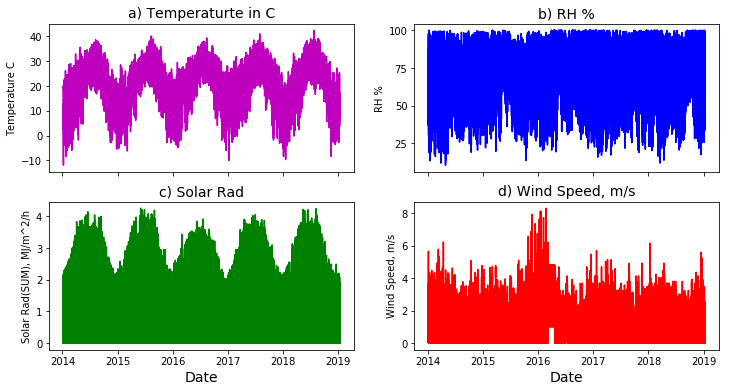

In [9]:
draw_weather(dfBla1)

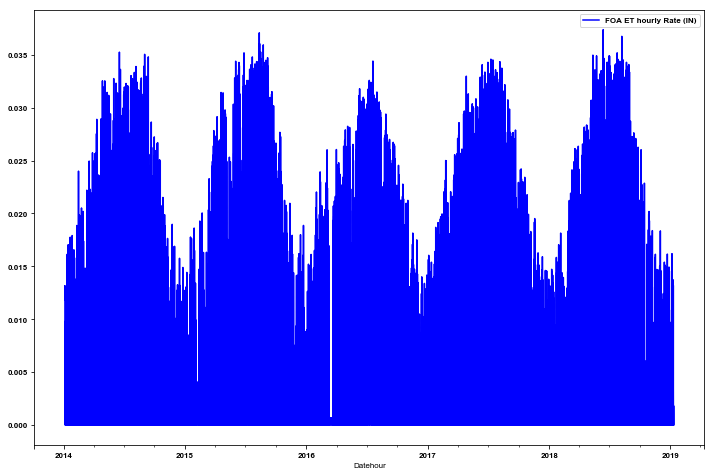

In [10]:
ETinch_Bla1.plot(kind='line',color='b',figsize=(12,8),legend=True)

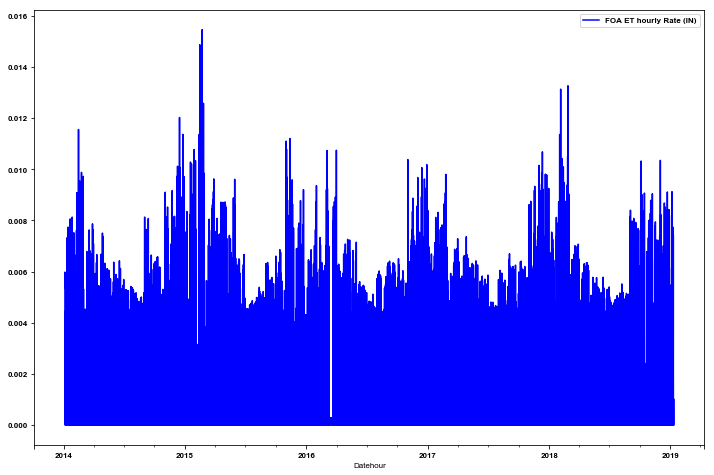

In [11]:
factor_ETBla1=normalizedET(ETinch_Bla1)
factor_ETBla1.plot(kind='line',color='b',figsize=(12,8),legend=True)

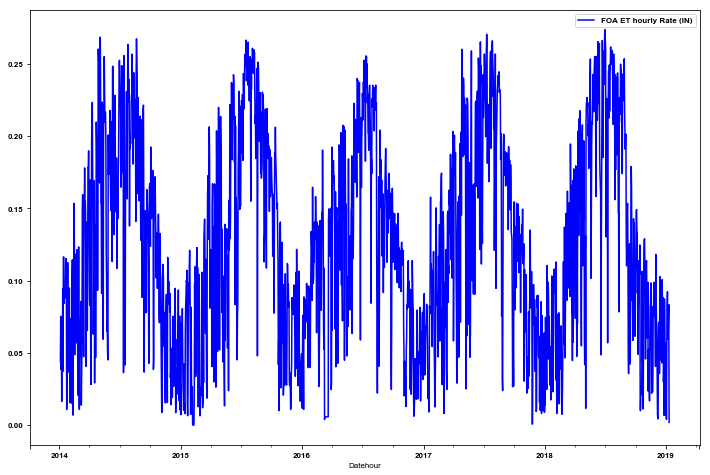

In [12]:
ETinch_Bla1_daily=ETinch_Bla1.resample("D").sum()
ETinch_Bla1_daily.plot(kind='line',color='b',figsize=(12,8),legend=True)

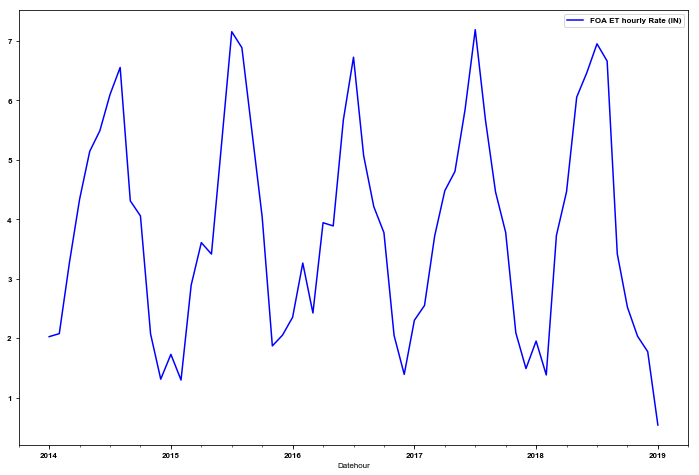

In [13]:
ETinch_Bla1_month=ETinch_Bla1.resample("M").sum()
ETinch_Bla1_month.plot(kind='line',color='b',figsize=(12,8),legend=True)

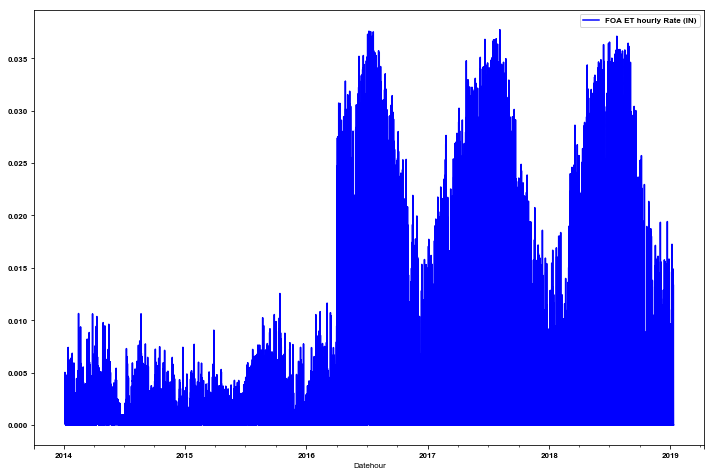

In [14]:
#Second weather station

Inputfile="procblaET2.csv"
Outputfile="HourlyET_blaET2.csv"
Latitude=30.026  # degree
Longitude=97.928 # degree 
Elev=254.8128      #elevtion above sea level in m
Windheight=2.5   

dfMaster = pd.read_csv(Inputfile,skiprows=range(1,3))
dfMaster=prepare_WeatherData(dfMaster)
df1=rearrange_dataframe(dfMaster)
dfBla2=df1
ETinch_Bla2=ET_cal(df1,Latitude,Longitude,Elev,Windheight,Outputfile,Humidty=False,Solar=False)
ETinch_Bla2.plot(kind='line',color='b',figsize=(12,8),legend=True)

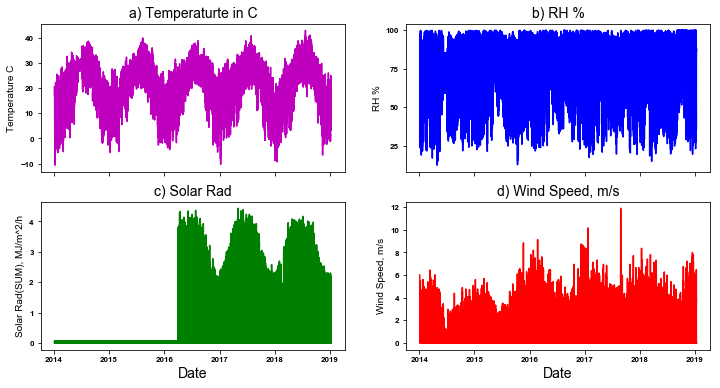

In [15]:
draw_weather(dfBla2)

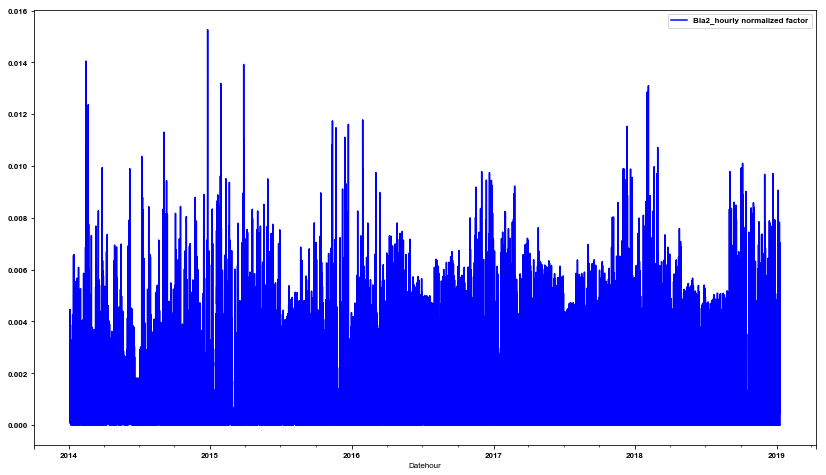

In [16]:
factor_ETBla2=normalizedET(ETinch_Bla2)
factor_ETBla2.plot(kind='line',color='b',figsize=(14,8),label='Bla2_hourly normalized factor',legend=True)

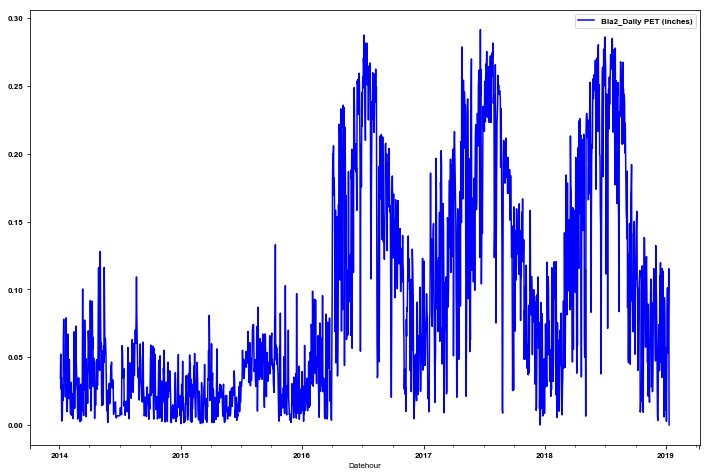

In [17]:
ETinch_Bla2_daily=ETinch_Bla2.resample("D").sum()
ETinch_Bla2_daily.plot(kind='line',color='b',figsize=(12,8),label='Bla2_Daily PET (inches)',legend=True)

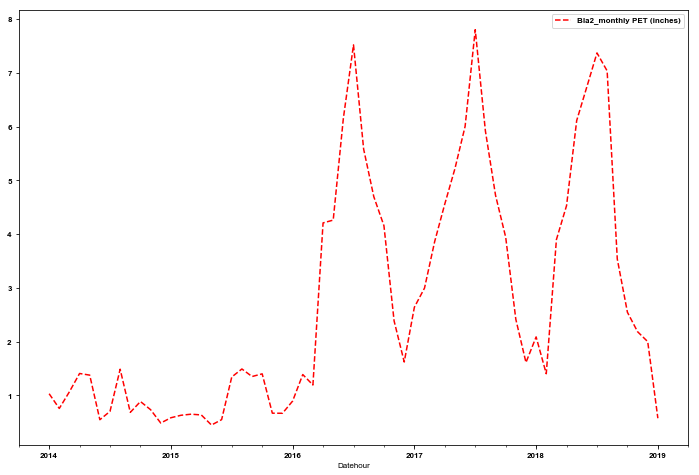

In [19]:
ETinch_Bla2_month=ETinch_Bla2.resample("M").sum()
ETinch_Bla2_month.plot(kind='line',color='r',style='--',figsize=(12,8),label='Bla2_monthly PET (inches)',legend=True)

In [20]:
### the third weater station

fileweatherSAT='722530dat_origional_data_v1.csv'
Outputfile='722530dat_origional_data_out.csv'


SATweather=pd.read_csv(fileweatherSAT,sep=',')
SATweather["Datehour"]=pd.to_datetime(SATweather[['year','month','day','hour','minute']],utc=True)
SATweather=SATweather.fillna(method='ffill').fillna(method='bfill')
SATweather=SATweather.set_index(SATweather['Datehour'])
SATweather.index = SATweather.index - pd.DateOffset(hours=6)

In [21]:
SATweather.isnull().sum()

year        0
month       0
day         0
hour        0
minute      0
Spdmph      0
Tempf       0
Dewpf       0
DIR         0
Datehour    0
dtype: int64

In [22]:
#SATweather.index = SATweather.index.dt.tz_localize('UTC').dt.tz_convert('US/Central')
SATweather=SATweather.resample('H').mean().ffill().bfill()
SATweather['Temp, *C'] = (SATweather['Tempf'] - 32) / 1.8
SATweather['DewPt, *C'] = (SATweather['Dewpf'] - 32) / 1.8
SATweather['Wind Speed, m/s'] = SATweather['Spdmph'] * 0.44704  
SATweather['Temp, *C'] = (SATweather['Tempf'] - 32) / 1.8
SATweather['DewPt, *C'] = (SATweather['Dewpf'] - 32) / 1.8
SATweather['Wind Speed, m/s'] = SATweather['Spdmph'] * 0.44704  


In [23]:
df1 = SATweather['2003-01-01 00:00:00':'2018-05-01 00:00:00'].filter(items=
         ['Datehour','DewPt, *C', 'Temp, *C', 'Wind Speed, m/s']) 
dfSAT=df1
Latitude=29.544  # degree
Longitude=98.484 # degree 
Elev=240.5      #elevtion above sea level in m
Windheight=2.5     # in m
ETinch_SAT=ET_cal(df1,Latitude,Longitude,Elev,Windheight,Outputfile,Humidty=True,Solar=True)
ETinch_SAT_daily=ETinch_SAT['2013-12-31 23:00:00-06:00':].resample("D").sum()
ETinch_SAT_month=ETinch_SAT['2013-12-31 23:00:00-06:00':].resample("M").sum()

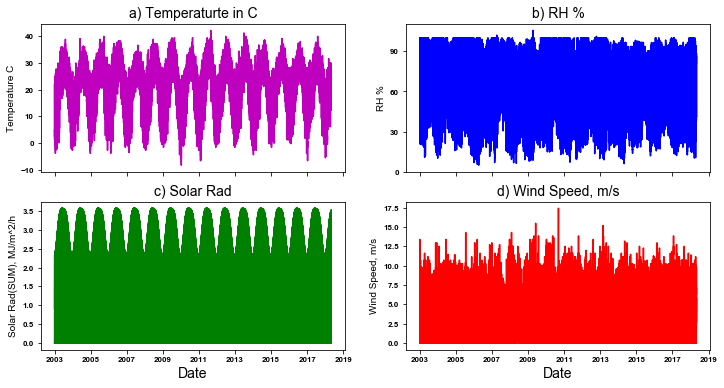

In [24]:
draw_weather(dfSAT)

In [25]:
SATweather.isnull().sum()

year               0
month              0
day                0
hour               0
minute             0
Spdmph             0
Tempf              0
Dewpf              0
DIR                0
Temp, *C           0
DewPt, *C          0
Wind Speed, m/s    0
dtype: int64

In [26]:
factor_SAT=normalizedET(ETinch_SAT)

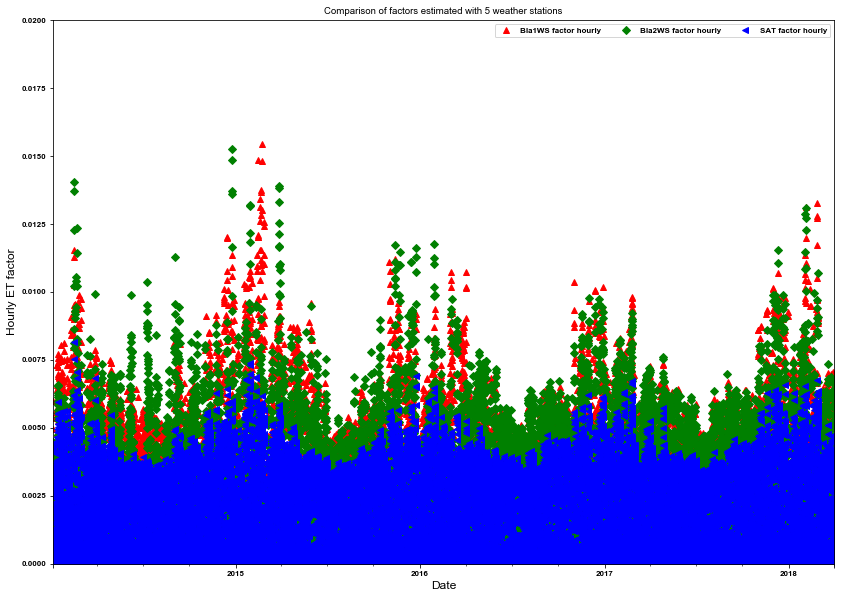

In [27]:
factor_ETBla1.name='Bla1WS factor hourly'
factor_ETBla2.name='Bla2WS factor hourly'
factor_SAT.name='SAT factor hourly'

fig = plt.figure(figsize=(14, 10))
factor_ETBla1.plot(color='r',style='^',legend=True)
factor_ETBla2.plot(color='g',style='D',legend=True)
factor_SAT.plot(color='b',style='<',legend=True)

plt.title('Comparison of factors estimated with 5 weather stations')
plt.ylabel('Hourly ET factor',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.xlim(['2014-01-04 00:00:00','2018-04-01 00:00:00'])
plt.ylim([0,0.02])
plt.legend(loc='best',ncol=3)
plt.show()

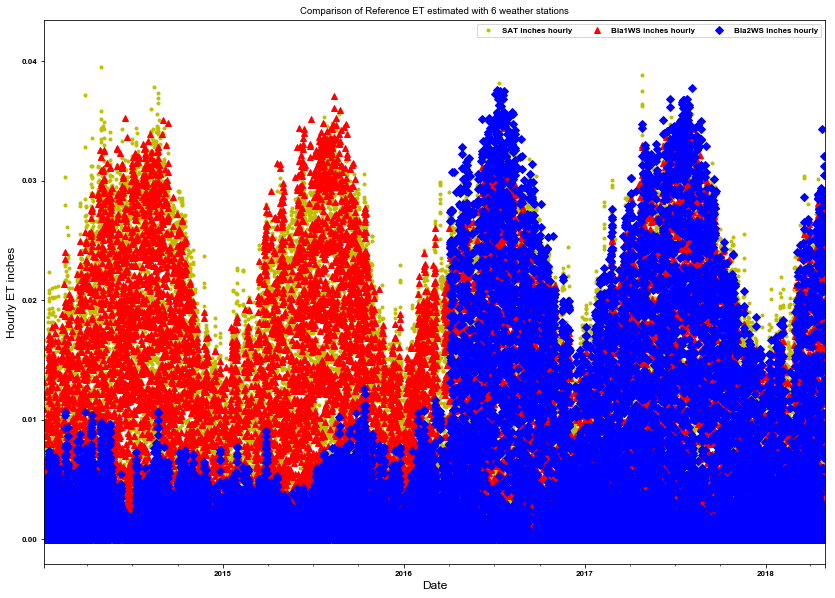

In [28]:
ETinch_Bla1.name='Bla1WS inches hourly'
ETinch_Bla2.name='Bla2WS inches hourly'
ETinch_SAT.name='SAT inches hourly'

fig = plt.figure(figsize=(14, 10))
ETinch_SAT.plot(color='y',style='.',legend=True)
ETinch_Bla1.plot(color='r',style='^',legend=True)
ETinch_Bla2.plot(color='b',style='D',legend=True)


plt.title('Comparison of Reference ET estimated with 6 weather stations')
plt.ylabel('Hourly ET inches',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.xlim(['2014-01-04 00:00:00','2018-05-01 00:00:00'])
plt.legend(loc='best',ncol=3)
plt.show()

In [29]:
### calcualted refernece ET saved to files.      

ETinch_Bla1.to_csv("ETinchbla1.csv")
ETinch_Bla2.to_csv("ETinchbla2.csv")
ETinch_SAT.to_csv("ETinchSAT.csv")                     


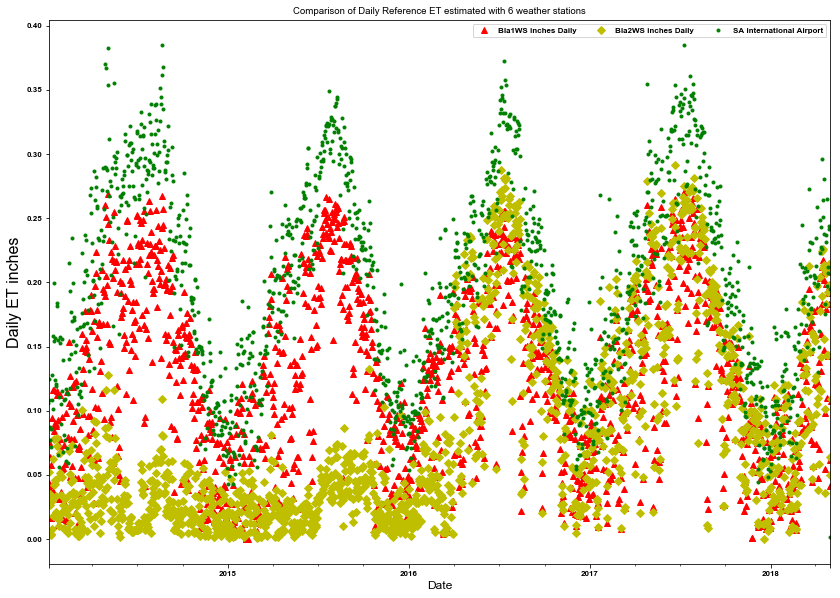

In [30]:
ETinch_Bla1_daily.name='Bla1WS inches Daily'
ETinch_Bla2_daily.name='Bla2WS inches Daily'
ETinch_SAT_daily.name='SA'
fig = plt.figure(figsize=(14, 10))
ETinch_Bla1_daily.plot(color='r',style='^',legend=True)
ETinch_Bla2_daily.plot(color='y',style='D',legend=True)
ETinch_SAT_daily.plot(color='g',style='.',legend=True)

plt.title('Comparison of Daily Reference ET estimated with 6 weather stations')
plt.ylabel('Daily ET inches',fontsize=16)
plt.xlabel('Date',fontsize=12)
plt.xlim(['2010-01-04 00:00:00','2018-05-01 00:00:00'])
plt.legend(loc='best',ncol=3)
plt.show()

In [31]:
### TWDB pan evaporation at the grid 709
fileETmonth='etQ709.txt'
TWDB_ET=read_TWDBlakesurface(fileETmonth)

# fileETmonth=r'C:\y_model\TWDB_lakesurfaceET\twdb_data\etQ808.txt'


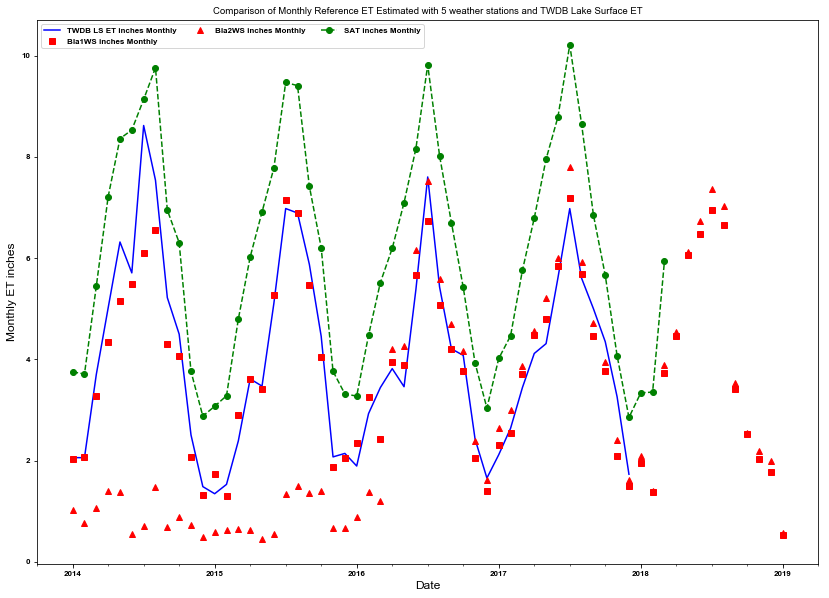

In [32]:
ETinch_Bla1_month.name='Bla1WS inches Monthly'
ETinch_Bla2_month.name='Bla2WS inches Monthly'
ETinch_SAT_month.name='SAT inches Monthly'

TWDB_ET_month=TWDB_ET['2014-01-01':'2017-12-31']['ETM'].resample('M').mean()
TWDB_ET_month.name='TWDB LS ET inches Monthly'
fig = plt.figure(figsize=(14, 10))
TWDB_ET_month.plot(color='b',style='-',legend=True)
ETinch_Bla1_month.plot(color='r',linestyle='',marker='s',legend=True)
ETinch_Bla2_month.plot(color='r',style='^',legend=True)
ETinch_SAT_month['2014-01-01':'2018-04-1'].plot(color='g',linestyle='--',marker='o',legend=True)
plt.title('Comparison of Monthly Reference ET Estimated with 5 weather stations and TWDB Lake Surface ET')
plt.ylabel('Monthly ET inches',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.legend(loc='best',ncol=3)
plt.show()

In [ ]:
#the following section is to recombine the factors to multiply the 

In [33]:
ETinch_SAT.head()

Datehour
2003-01-01 00:00:00    0.000829
2003-01-01 01:00:00    0.000587
2003-01-01 02:00:00    0.000593
2003-01-01 03:00:00    0.000454
2003-01-01 04:00:00    0.000802
Freq: H, Name: SAT inches hourly, dtype: float64

In [34]:
ETinch_Bla1.head()

Datehour
2014-01-04 13:00:00    0.011860
2014-01-04 14:00:00    0.013176
2014-01-04 15:00:00    0.010900
2014-01-04 16:00:00    0.006443
2014-01-04 17:00:00    0.001679
Name: Bla1WS inches hourly, dtype: float64

In [35]:
PET_Bla1=ETinch_SAT[:'2014-01-05 00:00:00']
PET_Bla2=ETinch_Bla1['2014-01-05 00:00:00':'2017-12-31 00:00:00']


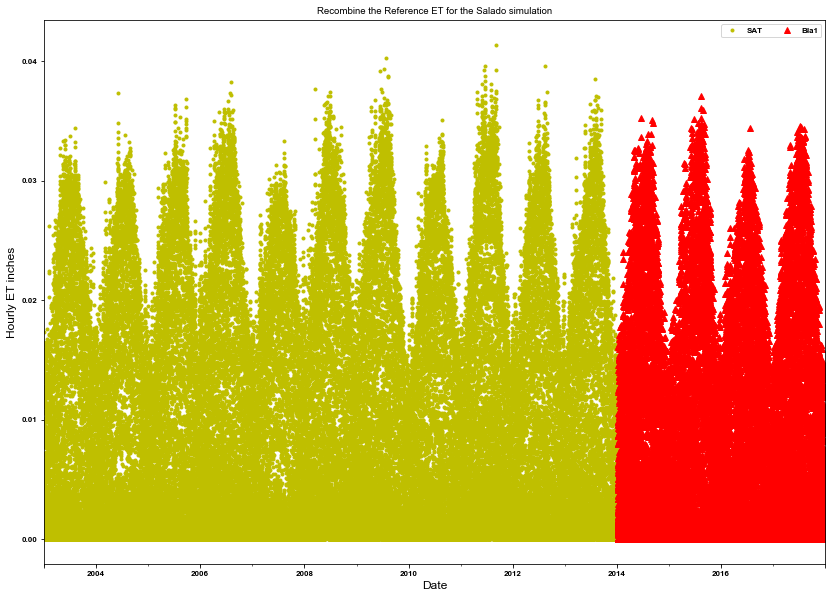

In [36]:
fig = plt.figure(figsize=(14, 10))
PET_Bla1.plot(color='y',style='.',label='SAT',legend=True)
PET_Bla2.plot(color='r',style='^',label='Bla1',legend=True)

plt.title('Recombine the Reference ET for the Salado simulation')
plt.ylabel('Hourly ET inches',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.xlim(['2003-01-01 00:00:00','2017-12-31 00:00:00'])
plt.legend(loc='best',ncol=3)
plt.show()

In [37]:
PET_Bla1.remame='SaladoET'
PET_Bla2.remame='SaladoET'
PET_Bla=PET_Bla1.combine_first(PET_Bla2)
#PET_Sal=PET_Sal.combine_first(PET_Sal3)


In [38]:
PET_Bla.isnull().sum()

0

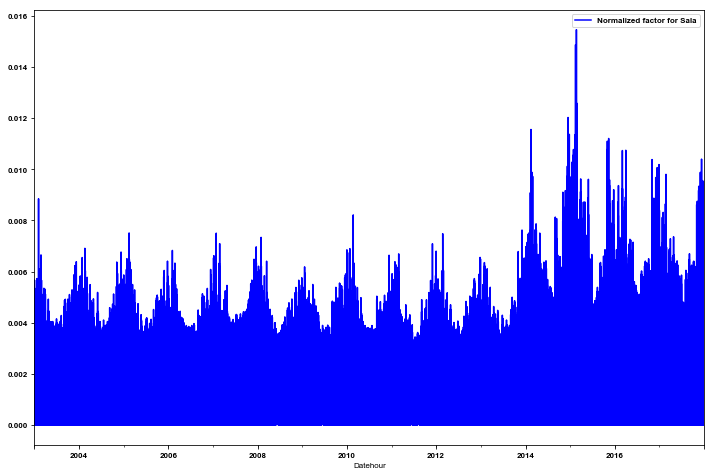

In [39]:
factor_Bla=normalizedET(PET_Bla)
factor_Bla.plot(kind='line',color='b',figsize=(12,8),label='Normalized factor for Sala',
                    xlim=['2003-01-01 00:00:00','2017-12-31 23:00:00'],legend=True)


In [40]:
factor_Bla.isnull().sum()

0

In [41]:
TWDB_ETh=TWDB_ET['2003-01-01 00:00:00':'2017-12-31 23:00:00']['ETM']

In [42]:
BlaPEThourly=TWDB_ETh*factor_Bla
BlaPETdaily=BlaPEThourly.resample('D').sum()
BlaPETmonthly=BlaPEThourly.resample('M').sum()

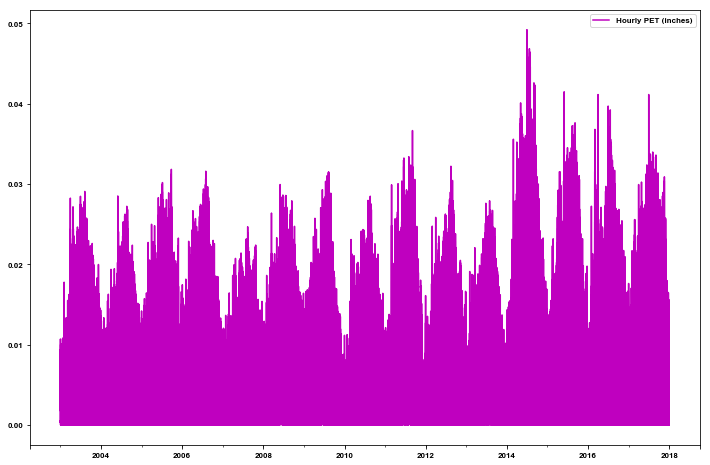

In [43]:
BlaPEThourly.plot(kind='line',color='m',figsize=(12,8),label='Hourly PET (inches)',legend=True)

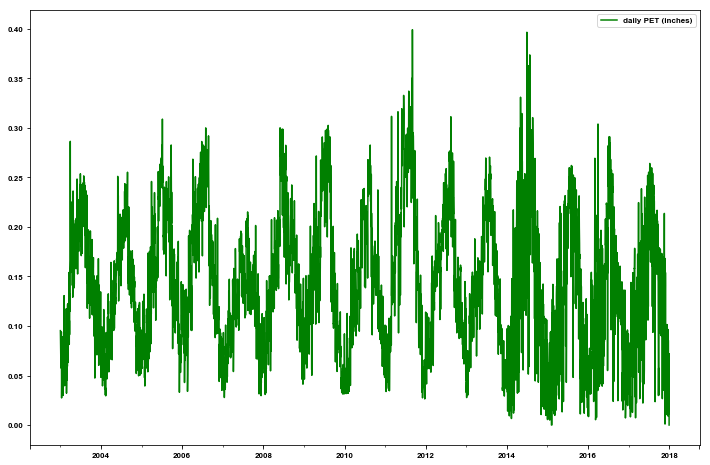

In [44]:
BlaPETdaily.plot(kind='line',color='g',figsize=(12,8),label='daily PET (inches)',legend=True)

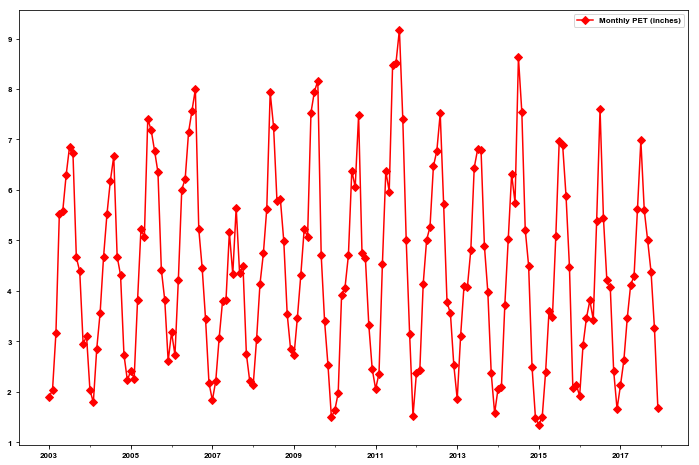

In [45]:
BlaPETmonthly.plot(kind='line',marker='D',color='r',figsize=(12,8),label='Monthly PET (inches)',legend=True)